In [55]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import time
import wandb
import pytorch_lightning as pl

import FunctionCollection as fc
import importlib
fc = importlib.reload(fc)
import os
import sqlite3
%matplotlib notebook

In [34]:
path = r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning'

run_name = 'Muon_Angle_m21'

args = {'N_edge_feats': 6,
        'N_dom_feats': 10,
        'N_targets': 2,
        'N_outputs': 3,
        'N_metalayers': 1,
        'N_hcs': 64,
        'diagonal_cov': True,
        'wandb_activated': False,
        'type': 'Spherical_NLLH',
        'zenith': True,
        'id': '222t',#wandb.util.generate_id()[:4],
        'eps': 1e-5,
        'lr': 0.0209,
        'output_offset': [3.14,1.57],
        'filename': 'rasmus_classification_muon_1500k.db',#dev_level7_mu_e_tau_oscweight_000.db #rasmus_classification_muon_3neutrino_3mio.db #dev_level7_oscNext_IC86_003.db
        'features': 'pulse_width, lc, SRTInIcePulses, string, dom, charge_log10, time, dom_x, dom_y, dom_z',
        'targets': 'event_no, azimuth, zenith, energy_log10, stopped_muon, muon_track_length',
        'TrTV': (0,1,1),
        'SRT_clean': False
       }

In [11]:
with sqlite3.connect(r"C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\raw_data\Nu_lvl7_1Mio_unscaled_SRT.db") as con:
    query = "SELECT event_no FROM truth"
    old_event_nos = pd.read_sql(query,con)

In [27]:
with sqlite3.connect(r"C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\raw_data\dev_level7_mu_e_tau_oscweight_newfeats_unscaled.db") as con:
    query = "SELECT event_no FROM truth"
    event_nos = pd.read_sql(query,con)

In [46]:
ind = event_nos.isin(old_event_nos.values)

In [72]:
event_nos = event_nos[(~ind).values].sample(1000000).values.reshape(-1)

In [13]:
# filepath = os.path.join(path,'raw_data/dev_level7_oscNext_IC86_003/data')
# # event_nos = pd.read_pickle(os.path.join(path,f'checkpoints/{run_name}_{args["id"]}/test_event_nos.pkl')).iloc[:1000000]


# tf = pd.read_pickle(r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\datasets\transformers.pkl')
# time_center, time_scale = tf['features']['time'].center_[0], tf['features']['time'].scale_[0]
# charge_center, charge_scale = tf['features']['charge_log10'].center_[0], tf['features']['charge_log10'].scale_[0]
# def x_transform(df):
#     df['charge_log10'] = (df['charge_log10'] - charge_center)/charge_scale
#     df['dom_time'] = (df['dom_time'] - time_center)/time_scale
#     df[['dom_x','dom_y','dom_z']] /= 300
#     return torch.tensor(df.values)
# def y_transform(df):
#     return torch.tensor(df.values)

filepath = os.path.join(path,'raw_data')

########### FOR UNSCALED DATA
# centers = pd.DataFrame({'charge_log10': [-0.033858],
#                         'dom_time': [10700.0],
#                         'dom_x': [0],
#                         'dom_y': [0],
#                         'dom_z': [0],
#                         'width': [4.5],
#                         'rqe': [1.175]})
# scalers = pd.DataFrame({'charge_log10': [0.274158],
#                         'dom_time': [2699.0],
#                         'dom_x': [300],
#                         'dom_y': [300],
#                         'dom_z': [300],
#                         'width': [3.5],
#                         'rqe': [0.175]})
########### FOR SCALED DATA
centers = pd.DataFrame({'charge_log10': [0],
                        'time': [0],
                        'dom_x': [0],
                        'dom_y': [0],
                        'dom_z': [0],
                        'lc': [0.5],
                        'SRTInIcePulses': [0.5],
                        'string': [40],
                        'dom': [30],
                        'pulse_width': [4.5]})
scalers = pd.DataFrame({'charge_log10': [1],
                        'time': [1],
                        'dom_x': [1],
                        'dom_y': [1],
                        'dom_z': [1],
                        'lc': [0.5],
                        'SRTInIcePulses': [0.5],
                        'string': [20],
                        'dom': [15],
                        'pulse_width': [3.5]})

centers = centers[args['features'].split(', ')].values
scalers = scalers[args['features'].split(', ')].values

def x_transform(df):
    df = (df - centers)/scalers
    return torch.tensor(df.values)

y_centers = pd.DataFrame({'energy_log10': [2.28962877],
                          'azimuth': [3.17179598],
                          'zenith': [0.99478726],
                          'event_no': [0],
                          'stopped_muon': [0],
                          'muon_track_length': [0]})
y_scalers = pd.DataFrame({'energy_log10': [1.03477065],
                          'azimuth': [3.18754927],
                          'zenith': [1.11991644],
                          'event_no': [1],
                          'stopped_muon': [1],
                          'muon_track_length': [1]})

y_centers = y_centers[args['targets'].split(', ')].values
y_scalers = y_scalers[args['targets'].split(', ')].values

def y_transform(df):
    df = df*y_scalers + y_centers
    return torch.tensor(df.values)

# def y_transform(df):
#     return torch.tensor(df.values)

# from typing import List
# @torch.jit.script
# def batch_transform(x,events: List[int]):
#     tmp_x = x.unsqueeze(1) - x
#     cart = tmp_x[:,:,-3:]
    
#     rho = torch.norm(cart, p=2, dim=-1).unsqueeze(2)
#     rho_mask = rho.squeeze() != 0
#     if rho_mask.sum() != 0:
#         cart[rho_mask] = cart[rho_mask] / rho[rho_mask]
#     tmp_x = torch.cat([cart,rho,tmp_x[:,:,:-3]],dim=2)
#     return torch.cat([tmp_x.mean(1),tmp_x.std(1),tmp_x.min(1)[0],tmp_x.max(1)[0],x],dim=1)

In [14]:
dataset = fc.custom_db_dataset(filepath = filepath,
                               filename = args['filename'],
                               features = args['features'],
                               targets = args['targets'],
                               TrTV = args['TrTV'],
                              #  event_nos = event_nos.to_numpy().reshape(-1),#sets['train'].to_numpy().reshape(-1),
                               x_transform = x_transform,
                               y_transform = y_transform,
                            #    batch_transform = batch_transform,
                               shuffle = True,
                               SRT_clean = args['SRT_clean'],
                              #  reweighter = ze_reweighter
                               )

In [15]:
# train_loader, test_loader, val_loader = dataset.return_dataloaders(batch_size=512) #~0.6sec loading time pr. batch
data_loader = dataset.return_dataloader(batch_size=1024)

In [16]:
import Model_Loaders.Model_21 as M
M = importlib.reload(M)

Net = M.Load_model(args['type'],args)
model = Net.load_from_checkpoint(path + '/checkpoints/' + run_name + '_' + args['id'] + '/' + run_name + '_latest.ckpt')

if features = x, Charge should be at x[:,-5], time at x[:,-4] and pos at x[:,-3:]
Remember all accuracies are positive and defined to go towards 0 in the optimal case.


In [17]:
model.to(torch.device('cuda'))
pred, truth = fc.return_reco_truth(model,data_loader)

Batch: 100%|███████████████████████████████| 1465/1465 [26:25<00:00,  1.04it/s]

In [18]:
df_truth = pd.DataFrame(data=truth,columns=args['targets'].split(', '))
df_pred = pd.DataFrame(data=pred,columns=['azimuth_pred','zenith_pred','pred_sigma'])

In [37]:
df_pred[['azimuth_pred','zenith_pred']] += args['output_offset']

In [38]:
tmp = df_pred.azimuth_pred.copy()
tmp[(tmp - df_truth.azimuth).abs() > np.pi] -= (tmp - df_truth.azimuth).apply(np.sign)*2*np.pi

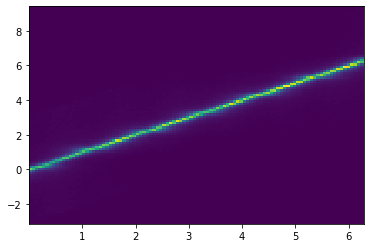

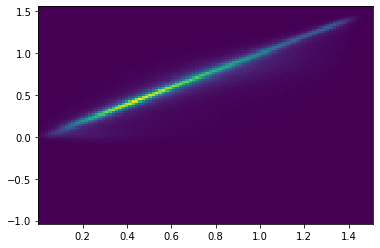

In [39]:
fig, ax = plt.subplots()
ax.hist2d(df_truth.azimuth, tmp, bins=100);

fig, ax = plt.subplots()
ax.hist2d(df_truth.zenith, df_pred.zenith_pred, bins=100);

$$ \sqrt{-2\cdot ln\left(coth(\kappa) - \frac{1}{\kappa}\right)} $$

In [49]:
kappa = df_pred.pred_sigma**2 + args['eps']
sigma = np.sqrt(-2*np.log((1+np.exp(-2*kappa))/(1-np.exp(-2*kappa)) - 1/kappa))*180/np.pi

<IPython.core.display.Javascript object>


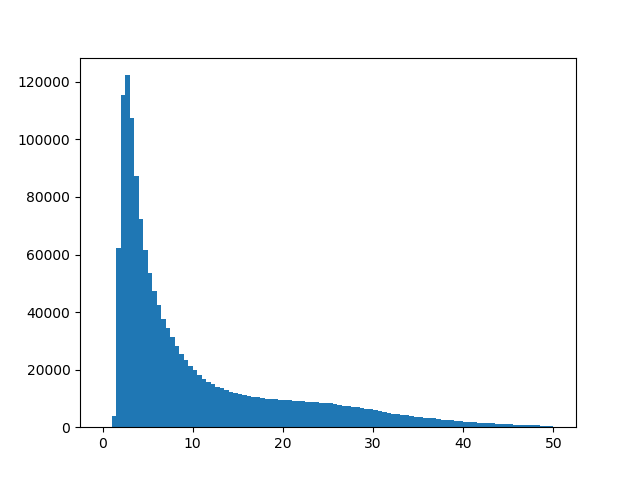

In [60]:
fig, ax = plt.subplots()
ax.hist(sigma,bins=100,range=(0,50));

In [65]:
def Omega(azp,zep,azt,zet):
    s1 = np.sin( zet + azt - azp )
    s2 = np.sin( zet - azt + azp )
    c1 = np.cos( zet - zep )
    c2 = np.cos( zet + zep )
    return np.arccos(0.5*np.abs(np.sin(zep))*( s1 + s2 ) + 0.5*(c1 + c2))*180/np.pi
solidA = Omega(df_pred.azimuth_pred,
               df_pred.zenith_pred,
               df_truth.azimuth,
               df_truth.zenith)

<IPython.core.display.Javascript object>


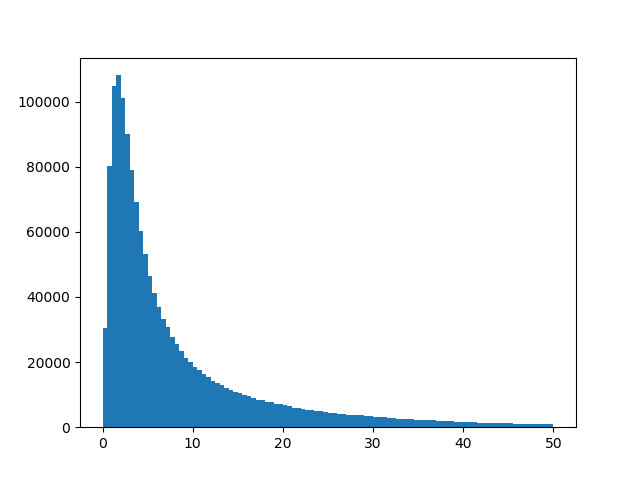

array([4.74605359, 8.54604613])

In [73]:
fig, ax = plt.subplots()
ax.hist(solidA,bins=100,range=(0,50));
np.quantile(solidA,(0.5,0.68))

<IPython.core.display.Javascript object>


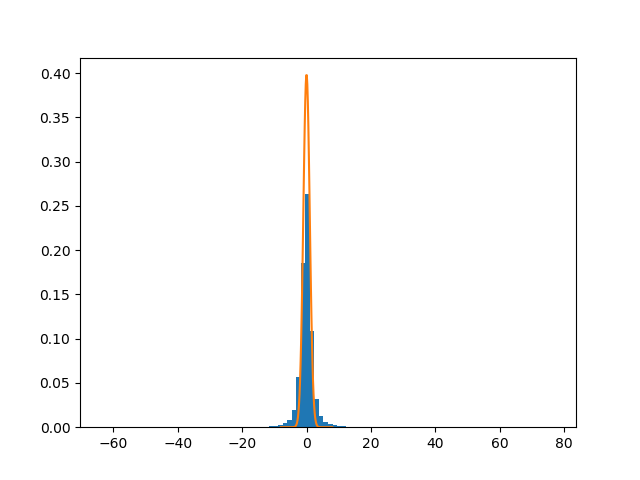

<IPython.core.display.Javascript object>


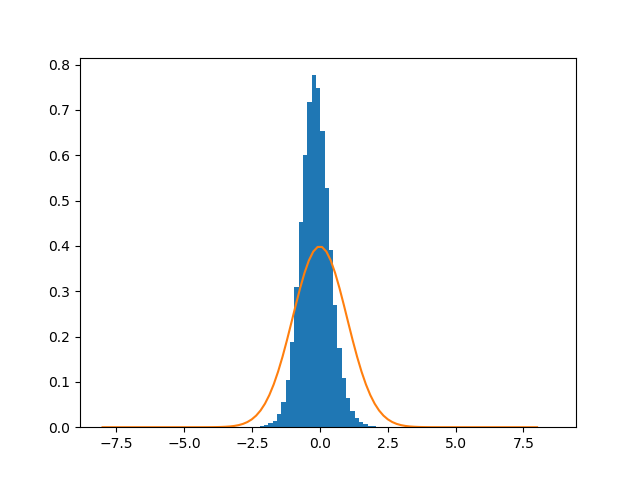

<IPython.core.display.Javascript object>


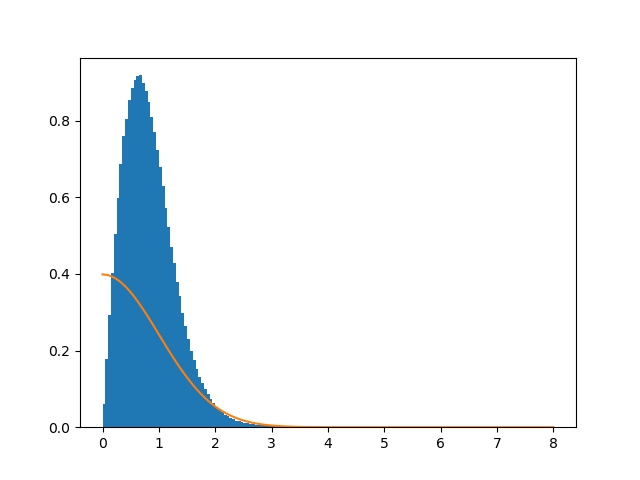

In [67]:
def gaussian(x, mu=0, sig=1):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) / (sig*np.sqrt(2*np.pi))

fig, ax = plt.subplots()
ax.hist((tmp-df_truth.azimuth)/sigma*180/np.pi,bins=100,density=True);
ax.plot(np.linspace(-8,8,100),gaussian(np.linspace(-8,8,100)))

fig, ax = plt.subplots()
ax.hist((df_pred.zenith_pred.abs()-df_truth.zenith)/sigma*180/np.pi,bins=100,density=True);
ax.plot(np.linspace(-8,8,100),gaussian(np.linspace(-8,8,100)))

fig, ax = plt.subplots()
ax.hist((solidA)/(sigma),bins=100,range=(0,5),density=True);
ax.plot(np.linspace(0,8,100),gaussian(np.linspace(0,8,100)))

<IPython.core.display.Javascript object>


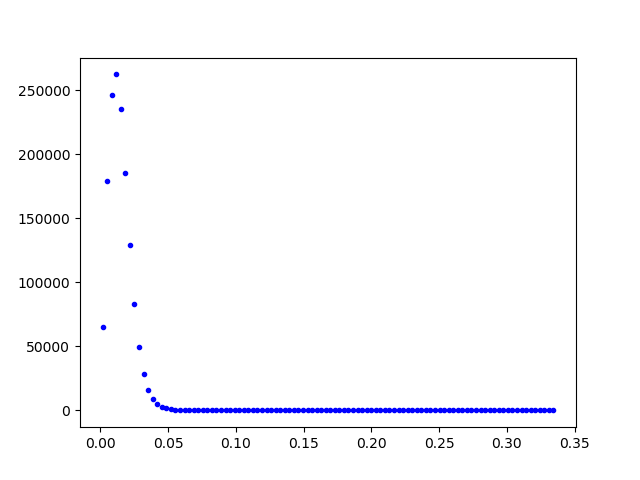

In [68]:
vals, binedges = np.histogram(solidA/sigma/180*np.pi,bins=100)
area = 2*(binedges[1:] - binedges[:-1])**2

fig,ax = plt.subplots()
ax.plot(0.5*(binedges[1:]+binedges[:-1]),vals,'b.')

In [70]:
print((solidA/(sigma) <= 1).sum()/1.5e6, 0.682689)
print((solidA/(sigma) <= 2).sum()/1.5e6, 0.954499)
print((solidA/(sigma) <= 3).sum()/1.5e6, 0.997300)

0.6848586666666666 0.682689
0.9803666666666667 0.954499
0.998358 0.9973


<IPython.core.display.Javascript object>


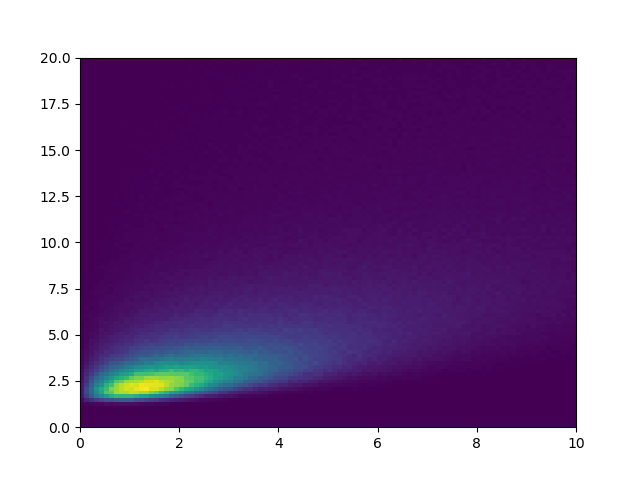

In [72]:
fig, ax = plt.subplots()
ax.hist2d(solidA,sigma,bins=100,range=((0,10),(0,20)));

In [74]:
df_pred.azimuth_pred = tmp
df_pred.zenith_pred = df_pred.zenith_pred.abs()
df_pred.pred_sigma = sigma

In [75]:
pd.concat([df_truth,df_pred],axis=1)

,event_no,azimuth,zenith,energy_log10,stopped_muon,muon_track_length,azimuth_pred,zenith_pred,pred_sigma
0,138674666.0,1.349233,0.543344,2.781607,0.0,1638.657168,1.269890,0.541098,2.091273
1,138675106.0,0.341489,0.812389,2.496842,1.0,1211.095527,0.155887,0.802602,5.306196
2,138678783.0,3.998877,0.665721,2.820676,0.0,1824.445392,4.016098,0.660168,1.548202
3,138682537.0,2.618876,0.119030,2.705125,0.0,1409.702515,3.117031,0.074725,3.801230
4,138685485.0,3.621367,0.544419,3.080137,1.0,1173.661867,3.457797,0.566893,7.235690
...,...,...,...,...,...,...,...,...,...
1499995,140544047.0,2.593930,0.435636,2.465056,1.0,1117.416002,2.601403,0.439520,4.429922
1499996,140544219.0,1.820517,0.918147,2.090240,1.0,379.463249,1.836564,0.849738,26.435945
1499997,140546730.0,3.296331,0.867890,2.551116,1.0,378.928062,2.806547,0.666708,34.381626
1499998,140547193.0,3.112284,0.210568,2.468115,1.0,970.570450,3.526920,0.002221,22.068626


In [76]:
# df_truth = pd.DataFrame(data=truth,columns=args['targets'].split(', '))
# df_pred = pd.DataFrame(data=pred,columns=['azimuth_pred','zenith_pred','azimuth_pred_sigma','zenith_pred_sigma'])
pd.concat([df_truth,df_pred],axis=1).to_csv(r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\predictions\Muon_Angle_m21_222t_1500k_MC_predictions.csv')

In [152]:
# df = pd.concat([df_truth,df_pred],axis=1)

[1.70037351 1.81535119 1.93032888 2.04530657 2.16028425 2.27526194
 2.39023962 2.50521731 2.620195   2.73517268 2.85015037 2.96512806
 3.08010574 3.19508343 3.31006112 3.4250388  3.54001649 3.65499418
 3.76997186 3.88494955 3.99992723] 1.7003735060379688 3.9999272348523673


<IPython.core.display.Javascript object>


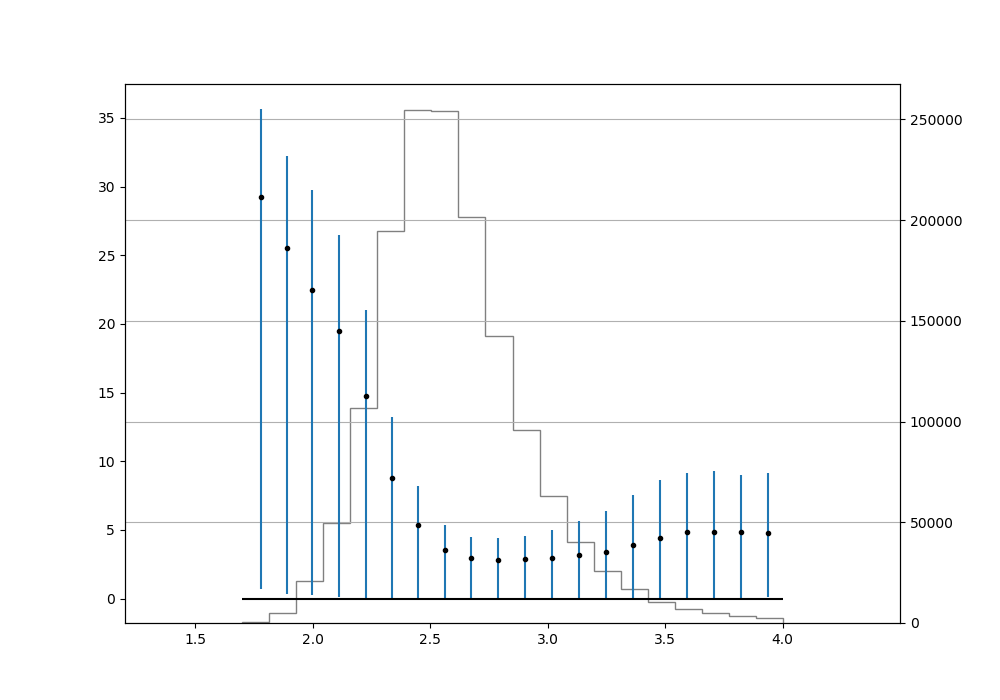

<IPython.core.display.Javascript object>


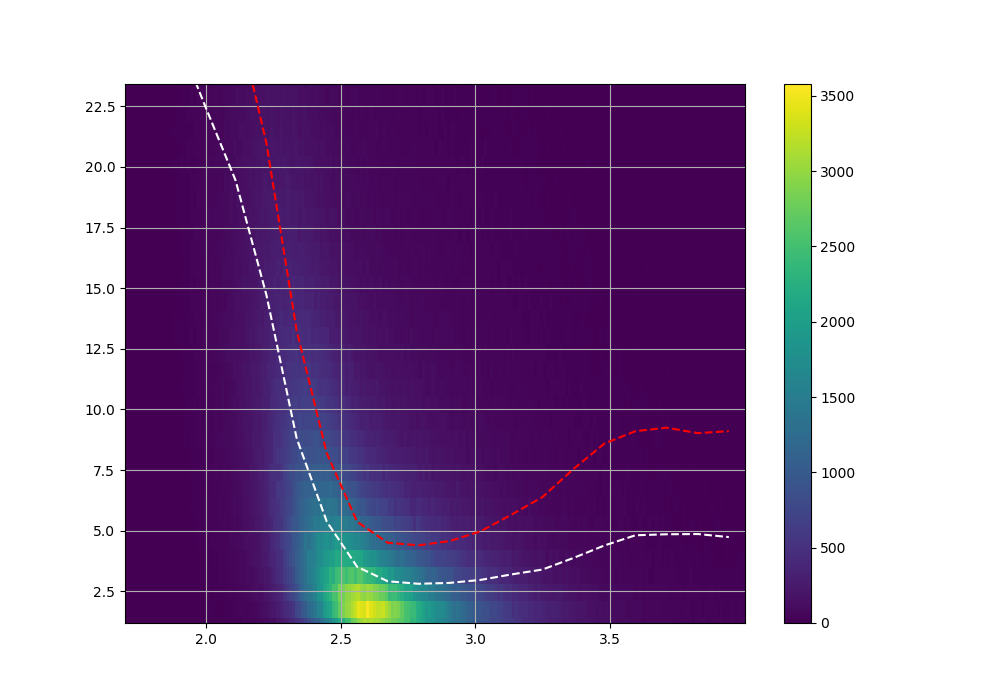

In [79]:
q = fc.performance_plot(solidA.to_numpy(),df_truth.energy_log10.to_numpy(),bins=20,zero_bounded=True);

In [154]:
Os = Omega(df.azimuth_pred,df.zenith_pred,df.azimuth,df.zenith)
Osr = Omega(df.azimuth_retro,df.zenith_retro,df.azimuth,df.zenith)

In [157]:
Os

array([17.64694973, 41.60831578, 23.07280645, ..., 13.14382546,
       44.91365204, 53.06938751])

[8.41628713e-05 1.99237818e-01 3.98391474e-01 5.97545129e-01
 7.96698784e-01 9.95852440e-01 1.19500610e+00 1.39415975e+00
 1.59331341e+00 1.79246706e+00 1.99162072e+00 2.19077437e+00
 2.38992803e+00 2.58908168e+00 2.78823534e+00 2.98738899e+00
 3.18654265e+00 3.38569630e+00 3.58484996e+00 3.78400362e+00
 3.98315727e+00] 8.416287128459917e-05 3.98315727079662


C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\FunctionCollection.py:205: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\FunctionCollection.py:215: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


[8.41628713e-05 1.99237818e-01 3.98391474e-01 5.97545129e-01
 7.96698784e-01 9.95852440e-01 1.19500610e+00 1.39415975e+00
 1.59331341e+00 1.79246706e+00 1.99162072e+00 2.19077437e+00
 2.38992803e+00 2.58908168e+00 2.78823534e+00 2.98738899e+00
 3.18654265e+00 3.38569630e+00 3.58484996e+00 3.78400362e+00
 3.98315727e+00] 8.416287128459917e-05 3.98315727079662


C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\FunctionCollection.py:205: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\FunctionCollection.py:215: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


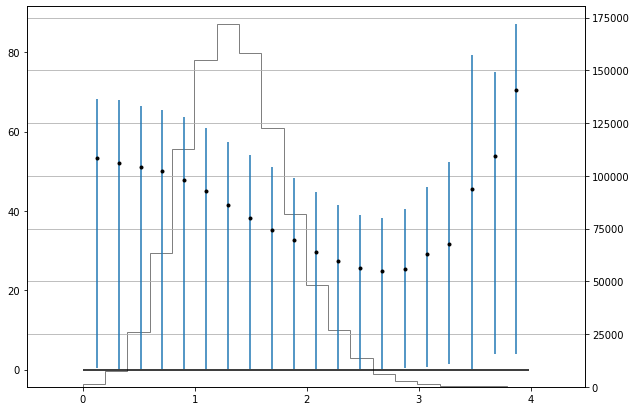

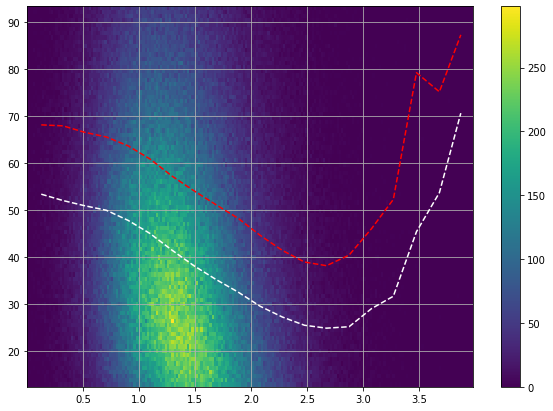

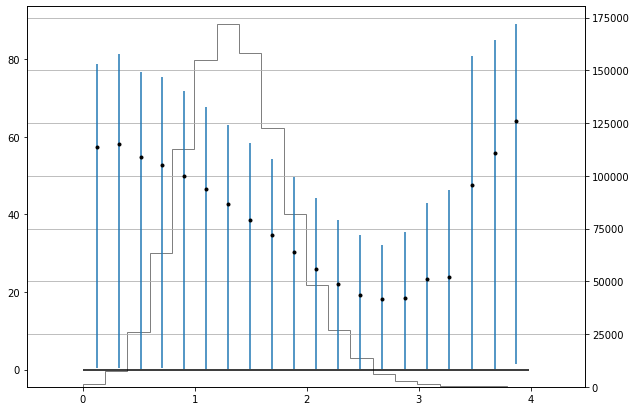

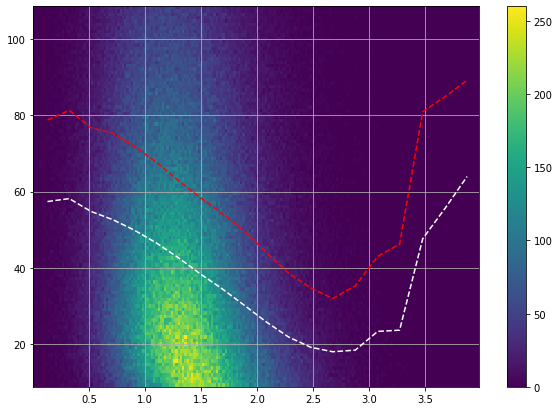

In [160]:
# fig, ax = plt.subplots()
# ax.hist2d()
q = fc.performance_plot(Os.to_numpy(),df.energy_log10.to_numpy(),bins=20,zero_bounded=True);
qr = fc.performance_plot(Osr.to_numpy(),df.energy_log10.to_numpy(),bins=20,zero_bounded=True);

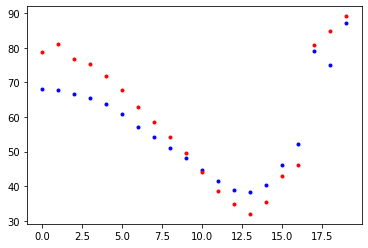

In [166]:
fig, ax = plt.subplots()
ax.plot(q[:,2],'b.',)
ax.plot(qr[:,2],'r.')

In [103]:
# wandb.finish()

_runtime,14458
_timestamp,1616003189
_step,10749
Train Loss,-0.33702
Train Acc,0.6416
epoch,27
Val Acc,0.65624
lr-Adam,0.00678


_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Train Loss,█▆▆▆▅▄▅▅▅▄▃▃▃▃▃▃▃▂▂▂▃▃▄▂▂▂▂▂▂▂▂▂▂▁▁▃▁▂▂▁
Train Acc,█▆▆▆▆▅▅▆▅▃▃▂▂▂▂▂▂▁▁▂▂▂▃▁▁▂▂▁▁▁▁▁▂▁▁▂▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
Val Acc,██▇▇▇▆▃▂▃▂▂▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁
lr-Adam,▁█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂
